# Spykshark decoding with Trodes data

### the purpose of the notebook is to utilize Dan Liu's spykshrk optimized decoder

Dan has only used nspike data, not Trodes data. 

I will start off by using Eric's lfdp file parsing, then create functions to reformat to spykshrk. 

In the future, I will need to create spykshrk file io from raw trodes functions.

step 0
go to spykshrk directory to use it as a module later

In [116]:
cd ~/Src/spykshrk_realtime/

/home/droumis/Src/spykshrk_realtime


## step 1 load trodes data with eric's lfdp



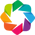

In [117]:
import loren_frank_data_processing as lfdp
# import replay_classification as replay
# import ripple_detection as ripple
import matplotlib.pyplot as plt
import holoviews as hv
# import inspect
# import os
import pandas as pd
import numpy as np
from ipywidgets import FloatProgress
from IPython.display import display
hv.notebook_extension('bokeh', 'matplotlib')
%matplotlib inline
%reload_ext autoreload
%autoreload 2

### issue!!! unresolved but low priority
with ipywidgets? 

jupyter nbextension enable --sys-prefix --py widgetsnbextension

In [118]:
animal_id = 'JZ1'
day, epoch = [1, 2]
ripple_area = 'ca1'
mu_areas = ['ca1', 'mec']
animals = {
    'JZ1': lfdp.Animal(short_name='JZ1', directory='../Roumis_2018/Raw-Data/JZ1')}
date = 20161114
areas = ['ca1']
mark_variables = ['channel_1_max', 'channel_2_max', 'channel_3_max',
                  'channel_4_max']

In [119]:
epoch_index = ('JZ1', 1, 2)
ntrode_key = ('JZ1', 1, 2, 1)
# mu_filenames = lfdp.multiunit.get_multiunit_filename(tetrode_key, animals)


In [120]:
ntrode_df = lfdp.make_tetrode_dataframe(animals)
ntrode_keys = ntrode_df.xs(epoch_index, drop_level=False).index.values

In [121]:
ca1_ntrode_keys = ntrode_df.xs(epoch_index, drop_level=False).query('area == "ca1"').index.values

In [122]:
ca1_ntrode_keys

array([('JZ1', 1, 2, 16), ('JZ1', 1, 2, 17), ('JZ1', 1, 2, 18),
       ('JZ1', 1, 2, 19), ('JZ1', 1, 2, 20), ('JZ1', 1, 2, 21),
       ('JZ1', 1, 2, 22), ('JZ1', 1, 2, 23), ('JZ1', 1, 2, 24),
       ('JZ1', 1, 2, 25), ('JZ1', 1, 2, 26), ('JZ1', 1, 2, 27),
       ('JZ1', 1, 2, 28), ('JZ1', 1, 2, 29), ('JZ1', 1, 2, 30)],
      dtype=object)

In [123]:
position_variables = ['linear_distance', 'trajectory_direction', 'speed']
position_df = lfdp.get_interpolated_position_dataframe(epoch_index, animals)
position_df['time'] = position_df.index #add the time index values as another col

### ISSUE!!! resolved
get_multiunit_dataframe is loading all spikes from a day.. why is it not respecting the epoch key

so it turns out that get_multiunit_dataframe is more of a helper function for get_multiunit_indicator_dataframe.. and that the epoch time filtering happens in the latter after the former is called

I'm fixing this by doing the filtering here after getting the epoch times separately

In [124]:
def get_trial_time(epoch_key, animals):
    tetrode_info = (
        lfdp.make_tetrode_dataframe(animals)
        .xs(epoch_key, drop_level=False))
    for tetrode_key in tetrode_info.index:
        lfp_df = lfdp.get_LFP_dataframe(tetrode_key, animals)
        if lfp_df is not None:
            break
    return lfp_df.index        

In [125]:
epoch_time = get_trial_time(epoch_index, animals)

In [ ]:
# f = FloatProgress(min=0, max=ntrode_keys.shape[0])
# f.value = 0
# display(f)
mu_times = []
for key_num, ntrode_key in enumerate(ntrode_keys):
    mu_times.append(lfdp.multiunit.get_multiunit_dataframe(ntrode_key, animals).loc[epoch_time.min():epoch_time.max()])
#     f.value += 1

In [126]:
# %store mu_times
%store -r mu_times

In [127]:
mu_times[0].head()

channel_1_max  channel_2_max  channel_3_max  channel_4_max
time                                                                       
00:28:00.210600          504.8          457.9          503.3          414.5
00:28:00.218100          622.2          612.9          683.4          593.6
00:28:00.223500         -189.5          -67.3          -80.2         -128.0
00:28:00.224900          670.9          634.9          739.2          607.0
00:28:00.235500          670.9          634.9          739.2          607.0

In [ ]:
# %store # view stores vars

In [129]:
cd ~/Src/Roumis_2018/

/home/droumis/Src/Roumis_2018


# step 2 create the functions to reformat to spykshrk encoder/decoder inputs


In [130]:
import src.converters as lfconvert

In [131]:
spyk_marks_df = lfconvert.multiunit_to_spykshrk(mu_times, ntrode_keys)

In [132]:
spyk_marks_df.tail(4)

c00  c01  c02  c03  c04  c05  c06  c07
day epoch elec_grp_id timestamp time                                           
1   2     30          289513310 2,895.1  -33   35  -27  -53  nan  nan  nan  nan
                      289513490 2,895.1    2   44  -12    5  nan  nan  nan  nan
                      289513570 2,895.1  149   28   -8  -30  nan  nan  nan  nan
                      289514340 2,895.1    2   44  -12    5  nan  nan  nan  nan

In [133]:
spyk_linpos_df = lfconvert.linear_position_to_spykshrk(position_df, ntrode_key)

In [134]:
spyk_linpos_df.tail()

linpos_flat  linvel_flat  seg_idx
day epoch timestamp time                                      
1   2     289514120 2,895.1         42.2          6.3    444.0
          289514186 2,895.1         42.2          6.3    444.0
          289514253 2,895.1         42.2          6.3    444.0
          289514320 2,895.1         42.2          6.3    444.0
          289514386 2,895.1         42.2          6.3    444.0

In [30]:
# def multiunit_to_spykshrk(mu_times, ntrode_keys):
#     allmu = []
#     for introde, ntrode_key in enumerate(ntrode_keys):
#         # format time multiindex
#         ntrode = ntrode_key[-1]
#         testmu = mu_times[ntrode-1].astype('int16').copy()
#         testmu['time'] = np.round(testmu.index.total_seconds(), decimals=5)
#         testmu.drop_duplicates(subset='time', inplace=True)
#         testmu['timestamp'] = testmu.time.apply(lambda row: (row*1e5)).astype('uint64') #in ns
#         testmu.set_index(['time', 'timestamp'], inplace=True) 

#         ### re-label channels to c00, c01, c02 .. cn
#         import re
#     #     testmu.rename(columns=lambda x: ('channel', 'c%02d' % (int(re.findall(r'\d+',x)[0])-1)), inplace=True)
#         testmu.rename(columns=lambda x: 'c%02d' % (int(re.findall(r'\d+',x)[0])-1), inplace=True)

#     #     testmustack = testmu.stack(level=-1).to_frame()
#     #     testmustack.index.rename('channel', level=-1, inplace=True)
#     #     testmustack.rename(columns=lambda x: ('sample', 's%02d' % x), inplace=True)

#         # join ntrode info
#         testmu['day'] = ntrode_key[1]
#         testmu['epoch'] = ntrode_key[2]
#         testmu['elec_grp_id'] = ntrode_key[3]
#         testmu.set_index(['day', 'epoch', 'elec_grp_id'], append=True, inplace=True)
#         testmu = testmu.reorder_levels(['day', 'epoch', 'elec_grp_id', 'timestamp', 'time'])
#         allmu.append(testmu)
#     return pd.concat(allmu)

# def linear_position_to_spykshrk(position_df,ntrode_key):
#     testpos = position_df[['linear_distance', 'speed', 'labeled_segments']]
#     testpos.columns= ['linpos_flat', 'linvel_flat', 'seg_idx']
#     testpos['time'] = testpos.index.total_seconds()
#     testpos['timestamp'] = testpos.time.apply(lambda row: (row*1e5)).astype('uint64')
#     testpos['day'] = ntrode_key[1]
#     testpos['epoch'] = ntrode_key[2]
#     testpos.set_index(['day', 'epoch', 'timestamp', 'time'], append=False, inplace=True)
#     testpos = testpos.reorder_levels(['day', 'epoch', 'timestamp', 'time'])
#     return testpos

In [31]:
# spk_amp_thresh = multiunit_to_spykshrk(mu_times, ca1_ntrode_keys)
# spk_amp_thresh.tail()

In [16]:
# spk_amp_thresh = spk_amp_thresh.iloc[spk_amp_thresh.index.get_level_values('elec_grp_id') >= 28]

In [32]:
# linflat_obj = linear_position_to_spykshrk(position_df,ntrode_key)

# step 3 use spykshrk data_containers


using dan's custom data-type specific pandas df's because his encoder needs custom methods like  
linpos:
- get_irregular_resampled (gets position via front fill for spike timestamps)
- get_mapped_single_axis (flattens linpos by adding offset to outer well linpos' using arm_coord)
- get_above_velocity 

spikes:
- get_simple_index (returns df with timestamp-type index)

These are often very simple static methods but create a readable api

### install 
https://github.com/daliu87/spykshrk_realtime
>> python setup.py build

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython



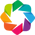

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [135]:
import pandas as pd
import numpy as np
import scipy as sp

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
import json
import os
import scipy.signal
import functools
import holoviews as hv

from holoviews.operation.datashader import aggregate, shade, datashade, dynspread, regrid
from holoviews.operation import decimate

import math

# from spykshrk.util import AttrDict
import spykshrk.franklab.filterframework_util as ff_util

from spykshrk.realtime.simulator import nspike_data

from spykshrk.franklab.pp_decoder.util import gaussian, normal2D, apply_no_anim_boundary, simplify_pos_pandas, \
                                                normal_pdf_int_lookup
from spykshrk.franklab.pp_decoder.pp_clusterless import OfflinePPDecoder, OfflinePPEncoder
from spykshrk.franklab.pp_decoder.data_containers import EncodeSettings, DecodeSettings, SpikeObservation, \
                                                         LinearPosition, StimLockout, Posteriors, \
                                                         FlatLinearPosition, SpikeWaves, SpikeFeatures, \
                                                         pos_col_format, DayEpochTimeSeries

from spykshrk.franklab.pp_decoder.visualization import DecodeVisualizer
from spykshrk.franklab.pp_decoder.decode_error import LinearDecodeError

import dask
import dask.dataframe as dd
import dask.array as da

import cloudpickle
        
%load_ext Cython

%matplotlib inline

hv.extension('matplotlib')
hv.extension('bokeh')
#pd.set_option('float_format', '{:,.2f}'.format)
pd.set_option('display.precision', 4)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 15)
#pd.set_option('display.width', 80)

idx = pd.IndexSlice

matplotlib.rcParams.update({'font.size': 14})

%load_ext autoreload
%autoreload 2

hv.Store.renderers['bokeh'].webgl = False

In [60]:
    cluster.close()
    client.close()

In [340]:
# start and connect to the dask local cluster (Scheduler and Workers)
try:
    cluster.close()
    client.close()
except:
    print("No cluster or client")
    
from dask.distributed import Client, LocalCluster

cluster = LocalCluster() #n_workers=2, threads_per_worker=6
client = Client(cluster)
client

<Client: scheduler='tcp://127.0.0.1:33053' processes=16 cores=16>

In [ ]:
# import dask.array as da
# x = da.random.random((10000, 10000, 10), chunks = (1000, 1000, 5))
# y = da.random.random((10000, 10000, 10), chunks=(1000, 1000, 5))
# z = (da.arcsin(x) + da.arccos(y)).sum(axis=(1,2))
# z.compute()

In [137]:
config_file = '/home/droumis/Src/spykshrk_realtime/config/bond_single_derecho.json'
# config_file = '/home/droumis/Src/spykshrk_realtime/config/JZ1_derecho.json'
config = json.load(open(config_file, 'r'))
encode_settings = EncodeSettings(config)

encode_settings.arm_coordinates

[[0, 69], [150, 252], [300, 404]]

In [138]:

def get_all_below_threshold(self, threshold):
    ind = np.nonzero(np.all(self.values < threshold, axis=1))
    return self.iloc[ind]

def get_any_above_threshold(self, threshold):
    ind = np.nonzero(np.any(self.values > threshold, axis=1))
    return self.iloc[ind]

def get_all_above_threshold(self, threshold):
    ind = np.nonzero(np.all(self.values > threshold, axis=1))
    return self.iloc[ind]


In [257]:
spk_ampS_test = SpikeFeatures.create_default(spk_amp_thresh, sampling_rate=1e5)
spk_ampS_test = get_all_above_threshold(spk_ampS_test, 0)
spk_ampS_test = get_any_above_threshold(spk_ampS_test, 400)
spk_ampS_test = get_all_below_threshold(spk_ampS_test, 2000)
use_spikes = spk_ampS_test

In [236]:
oneDlinpos = FlatLinearPosition.create_default(
        linflat_obj, sampling_rate=1e5, arm_coord=encode_settings.arm_coordinates
    )
use_pos = oneDlinpos

In [144]:
# position_nonan = oneDlinpos[oneDlinpos.all(axis=1)]
# position_nonan = position_nonan.astype('int')

# encoding/decoding with dask
create encode settings and run spykshrk encoder

In [262]:
encoder = OfflinePPEncoder(linflat=use_pos, spk_amp=use_spikes, speed_thresh=0, chunksize=1000,
                           encode_settings=encode_settings)

In [341]:
# %%prun -r -s cumulative
daskresults = encoder.run_encoder()

tornado.application - ERROR - Future <tornado.concurrent.Future object at 0x7f0fa04ebb38> exception was never retrieved: Traceback (most recent call last):
  File "/home/droumis/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 1069, in run
    yielded = self.gen.send(value)
  File "/home/droumis/anaconda3/lib/python3.6/site-packages/distributed/client.py", line 1335, in wait
    raise AllExit()
distributed.client.AllExit
distributed.core - WARNING - Event loop was unresponsive in Nanny for 1.92s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 2.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 2.67s.  This is often caused by long-running GIL-holding functions or movi

distributed.core - WARNING - Event loop was unresponsive in Nanny for 5.44s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 5.41s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 5.41s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 4.77s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 4.75s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - WARNING - Event loop was unresponsive in Nanny for 2.25s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 2.25s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 5.29s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 5.29s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 5.29s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - WARNING - Event loop was unresponsive in Nanny for 4.36s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 3.44s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 3.40s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 3.07s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 3.06s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - WARNING - Event loop was unresponsive in Nanny for 5.12s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 5.12s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Scheduler for 5.12s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 5.10s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 4.58s.  This is often caused by long-running GIL-holding functions or moving large chu

distributed.core - WARNING - Event loop was unresponsive in Nanny for 2.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 2.22s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 5.22s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 5.22s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 5.22s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - WARNING - Event loop was unresponsive in Nanny for 3.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 3.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 3.33s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 3.14s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 3.12s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - WARNING - Event loop was unresponsive in Nanny for 4.75s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 4.75s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 4.75s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 4.75s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 4.75s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - WARNING - Event loop was unresponsive in Nanny for 2.38s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 2.40s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 5.38s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 5.38s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 5.38s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - WARNING - Event loop was unresponsive in Nanny for 2.78s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 2.82s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 7.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 13.25s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 13.29s.  This is often caused by long-running GIL-holding functions or moving large chunk

distributed.core - WARNING - Event loop was unresponsive in Scheduler for 28.20s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 28.11s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 28.10s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 28.07s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 27.96s.  This is often caused by long-running GIL-holding functions or moving larg

distributed.core - WARNING - Event loop was unresponsive in Nanny for 11.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 11.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 11.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 11.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 11.53s.  This is often caused by long-running GIL-holding functions or moving large ch

distributed.core - WARNING - Event loop was unresponsive in Nanny for 1.27s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 1.27s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 1.27s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 1.27s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Scheduler for 1.27s.  This is often caused by long-running GIL-holding functions or moving large chu

distributed.core - WARNING - Event loop was unresponsive in Nanny for 1.44s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 1.44s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 1.44s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 1.44s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 1.44s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - WARNING - Event loop was unresponsive in Nanny for 1.61s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 1.61s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 1.61s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 1.61s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 1.61s.  This is often caused by long-running GIL-holding functions or moving large chunks 

In [343]:
daskresults[0]

x000  x001  x002  x003  x004  x005  x006  ...   x443  x444  x445  x446  x447  x448  x449
timestamp                                            ...                                           
168268250   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   0.0   0.0   0.0   0.0   0.0   0.0
169397210   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   0.0   0.0   0.0   0.0   0.0   0.0
169800070   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   0.0   0.0   0.0   0.0   0.0   0.0
170787040   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   0.0   0.0   0.0   0.0   0.0   0.0
170841610   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   0.0   0.0   0.0   0.0   0.0   0.0
...         ...   ...   ...   ...   ...   ...   ...  ...    ...   ...   ...   ...   ...   ...   ...
289205780   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   0.0   0.0   0.0   0.0   0.0   0.0
289206050   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   0.0   0.0   0.0   0.0   0.0   0.0
289233040   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   0.0   0.0   0.0   0.0   0.0   0.0
289390990   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   0.0   0.0   0.0   0.0   0.0   0.0
289413600   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   0.0   0.0   0.0   0.0   0.0   0.0

[648 rows x 450 columns]

In [344]:
%store daskresults
# %store -r daskresults

Stored 'daskresults' (tuple)


In [345]:
observ = []
observ_obj = []
observ_tet_list = []

tet_ids = np.unique(use_spikes.index.get_level_values('elec_grp_id'))
observ_tet_list = []
grp = use_spikes.groupby('elec_grp_id')

for tet_ii, (tet_id, grp_spk) in enumerate(grp):
    tet_result = daskresults[tet_ii]
    tet_result.set_index(grp_spk.index, inplace=True)
    observ_tet_list.append(tet_result)

observ = pd.concat(observ_tet_list)
observ_obj = SpikeObservation(observ.sort_index(level=['day', 'epoch', 
                                                               'timestamp', 'elec_grp_id']), )

observ_obj['elec_grp_id'] = observ_obj.index.get_level_values('elec_grp_id')
observ_obj.index = observ_obj.index.droplevel('elec_grp_id')

In [347]:
observ_obj['position'] = encoder.linflat.get_irregular_resampled(
    observ_obj.index.get_level_values('timestamp')
).get_mapped_single_axis().set_index(observ_obj.index)['linpos_flat']

distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.core - WARNING - Event loop was unresponsive in Nanny for 1.07s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.core - WARNING - Event loop was unresponsive in Nanny for 1.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.utils_perf - WARNING - full garbage collections 

In [348]:
observ_obj.head()

<NewCls: 6d6ed7e9-9d08-4e6e-9942-4480a73f35d4, shape: ((5, 452))>

In [349]:
# %%prun -r -s cumulative

# Run PP decoding algorithm
time_bin_size = 30
decode_settings = DecodeSettings(config)
decoder = OfflinePPDecoder(lin_obj=encoder.linflat, observ_obj=observ_obj,
                           encode_settings=encode_settings, decode_settings=decode_settings, 
                           which_trans_mat='simple', time_bin_size=time_bin_size, chunksize=1000)

In [350]:
posteriors = decoder.run_decoder()

Beginning likelihood calculation


distributed.nanny - WARNING - Worker exceeded 95% memory budget.  Restarting
distributed.nanny - WARNING - Worker process 24659 was killed by unknown signal
distributed.nanny - WARNING - Worker exceeded 95% memory budget.  Restarting
tornado.application - ERROR - Exception in callback <bound method Nanny.memory_monitor of <Nanny: tcp://127.0.0.1:33693, threads: 1>>
Traceback (most recent call last):
  File "/home/droumis/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 1026, in _run
    return self.callback()
  File "/home/droumis/anaconda3/lib/python3.6/site-packages/distributed/nanny.py", line 258, in memory_monitor
    self.process.process.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget.  Restarting
distributed.nanny - WARNING - Worker process 24620 was killed by unknown signal
distributed.nanny - WARNING - Worker exceeded 95% memor

KilledWorker: ("('_groupby_slice_apply-34898729c6855532954c114a1ce6520c', 0)", 'tcp://127.0.0.1:36087')

distributed.nanny - WARNING - Worker exceeded 95% memory budget.  Restarting
tornado.application - ERROR - Exception in callback <bound method Nanny.memory_monitor of <Nanny: tcp://127.0.0.1:36087, threads: 1>>
Traceback (most recent call last):
  File "/home/droumis/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 1026, in _run
    return self.callback()
  File "/home/droumis/anaconda3/lib/python3.6/site-packages/distributed/nanny.py", line 258, in memory_monitor
    self.process.process.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'
distributed.nanny - WARNING - Restarting worker


# Encoding/Decoding no dask

In [ ]:
encoder = OfflinePPEncoder(linflat=use_pos, spk_amp=use_spikes, speed_thresh=0, chunksize=1000,
                           encode_settings=encode_settings)

In [306]:
# %store -r results
results, spikes, positions = no_dask_run_encoder(encoder)

distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.core - WARNING - Event loop was unresponsive in Nanny for 1.64s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Scheduler for 2.13s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.utils_perf - WARNING - full garbage collecti

distributed.core - WARNING - Event loop was unresponsive in Nanny for 1.11s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Scheduler for 1.11s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.utils_perf - WARNING - full garbage collections took 50% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 50% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 50% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 47% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 50% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collecti

In [308]:
positions[0]

<NewCls: b5941620-dad9-44d6-95b7-73e2f50708ed, shape: ((648, 3))>

In [272]:
%store results
# %store spk_tet

distributed.core - WARNING - Event loop was unresponsive in Scheduler for 3.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 3.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 3.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


Stored 'results' (list)


AttributeError: Can't pickle local object 'partialclass.<locals>.NewCls'

In [305]:

def no_dask_run_encoder(encoder):
    grp = encoder.spk_amp.groupby('elec_grp_id')
    results = []
    spikes = []
    positions = []
    for tet_id, spk_tet in grp:
        spk_tet.index = spk_tet.index.droplevel('elec_grp_id')
        tet_lin_pos = encoder.linflat.get_irregular_resampled(
            spk_tet.index.get_level_values('timestamp')
        ).get_mapped_single_axis()
#         goodpos_ind = tet_lin_pos.all(axis=1).values
#         tet_lin_pos_thresh = tet_lin_pos[goodpos_ind]

#         spk_tet = spk_tet[goodpos_ind]
#         nodask_spk_tet = spk_tet.get_simple_index()

        results.append(nodask_compute_observ_tet(
            dec_spk=spk_tet,
            enc_spk=spk_tet.get_simple_index(),
            tet_lin_pos=tet_lin_pos,
            occupancy=encoder.occupancy,
            encode_settings=encoder.encode_settings))
        spikes.append(spk_tet)
        positions.append(tet_lin_pos.set_index(spk_tet.index))
    return results, spikes, positions

def nodask_compute_observ_tet(dec_spk, enc_spk, tet_lin_pos, occupancy, encode_settings):

    pos_distrib_tet = sp.stats.norm.pdf(np.expand_dims(encode_settings.pos_bins, 0),
                                        np.expand_dims(tet_lin_pos['linpos_flat'], 1),
                                        encode_settings.pos_kernel_std)
    
    mark_contrib = nodask_normal_pdf_int_lookup(np.expand_dims(dec_spk, 1),
                                         np.expand_dims(enc_spk, 0),
                                         encode_settings.mark_kernel_std)

    all_contrib = np.prod(mark_contrib, axis=2)

    del mark_contrib

    observ = np.matmul(all_contrib, pos_distrib_tet)

    del all_contrib

    # occupancy normalize
    observ = observ / (occupancy + 1e-10)

    # normalize each row
    observ_sum = observ.sum(axis=1)
    observ_sum_zero = observ_sum == 0
    observ[observ_sum_zero, :] = 1/(encode_settings.pos_bins[-1] - encode_settings.pos_bins[0])
    observ_sum[observ_sum_zero] = 1
    observ = observ / observ.sum(axis=1)[:, np.newaxis]

    ret_df = pd.DataFrame(observ, index=dec_spk.index,
                          columns=[pos_col_format(pos_ii, observ.shape[1])
                                   for pos_ii in range(observ.shape[1])])

    return ret_df

def nodask_normal_pdf_int_lookup(x, mean, std):
    max_amp = 2000
    norm_dist = sp.stats.norm.pdf(x=np.arange(-max_amp,max_amp), loc=0, scale=std)
#     mean = mean.astype('int')
#     print(x-mean+max_amp)
    return norm_dist[x-mean+max_amp]


## get encoding results into decoder friendly table

AttributeError: 'builtin_function_or_method' object has no attribute 'get_level_values'

In [310]:
observ = []
observ_obj = []
observ_tet_list = []

tet_ids = np.unique(use_spikes.index.get_level_values('elec_grp_id'))
observ_tet_list = []
grp = use_spikes.groupby('elec_grp_id')

for tet_ii, (tet_id, grp_spk) in enumerate(grp):
    tet_result = results[tet_ii]
    tet_result.set_index(grp_spk.index, inplace=True)
    observ_tet_list.append(tet_result)

observ = pd.concat(observ_tet_list)
observ_obj = SpikeObservation(observ.sort_index(level=['day', 'epoch', 
                                                               'timestamp', 'elec_grp_id']), )

observ_obj['elec_grp_id'] = observ_obj.index.get_level_values('elec_grp_id')
observ_obj.index = observ_obj.index.droplevel('elec_grp_id')

# observ_obj['position'] = (position_nonan.iloc[1:1000]['linpos_flat'])

In [316]:
observ_obj['position'] = encoder.linflat.get_irregular_resampled(
    observ_obj.index.get_level_values('timestamp')
).get_mapped_single_axis().set_index(observ_obj.index)['linpos_flat']

distributed.utils_perf - WARNING - full garbage collections took 44% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 45% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 45% CPU time recently (threshold: 10%)
distributed.core - WARNING - Event loop was unresponsive in Nanny for 1.35s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 1.36s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Scheduler for 1.36s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


## DECODE


In [334]:
# %%prun -r -s cumulative

# Run PP decoding algorithm
time_bin_size = 30
decode_settings = DecodeSettings(config)
decoder = OfflinePPDecoder(lin_obj=encoder.linflat, observ_obj=observ_obj,
                           encode_settings=encode_settings, decode_settings=decode_settings, 
                           which_trans_mat='simple', time_bin_size=time_bin_size, chunksize=1000)

In [339]:
# %%prun -r -s cumulative
posteriors = decoder.run_decoder()

Beginning likelihood calculation


distributed.nanny - WARNING - Worker exceeded 95% memory budget.  Restarting
distributed.nanny - WARNING - Worker process 12967 was killed by unknown signal
distributed.scheduler - ERROR - Workers don't have promised key. This should never occur: ['tcp://127.0.0.1:36849'], ('_groupby_slice_apply-bfa628c388926632a20e97c27a44b215', 0)
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key. This should never occur: ['tcp://127.0.0.1:36849'], ('_groupby_slice_apply-bfa628c388926632a20e97c27a44b215', 1)
NoneType: None
distributed.client - WARNING - Couldn't gather keys {"('_groupby_slice_apply-bfa628c388926632a20e97c27a44b215', 0)": ['tcp://127.0.0.1:36849'], "('_groupby_slice_apply-bfa628c388926632a20e97c27a44b215', 1)": ['tcp://127.0.0.1:36849']}
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget.  Restarting
distributed.nanny - WARNING - Worker process 12970 was killed by unknown signal
distributed.sched

decoder deleting


distributed.nanny - WARNING - Worker exceeded 95% memory budget.  Restarting
distributed.nanny - WARNING - Worker process 13357 was killed by unknown signal
distributed.scheduler - ERROR - Workers don't have promised key. This should never occur: ['tcp://127.0.0.1:34721'], ('_groupby_slice_apply-bfa628c388926632a20e97c27a44b215', 0)
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key. This should never occur: ['tcp://127.0.0.1:34721'], ('_groupby_slice_apply-bfa628c388926632a20e97c27a44b215', 1)
NoneType: None
distributed.client - WARNING - Couldn't gather keys {"('_groupby_slice_apply-bfa628c388926632a20e97c27a44b215', 0)": ['tcp://127.0.0.1:34721'], "('_groupby_slice_apply-bfa628c388926632a20e97c27a44b215', 1)": ['tcp://127.0.0.1:34721']}
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget.  Restarting
distributed.nanny - WARNING - Worker process 13508 was killed by unknown signal
distributed.sched

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget.  Restarting
distributed.nanny - WARNING - Worker process 15181 was killed by unknown signal
distributed.scheduler - ERROR - Workers don't have promised key. This should never occur: ['tcp://127.0.0.1:45151'], ('_groupby_slice_apply-bfa628c388926632a20e97c27a44b215', 0)
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key. This should never occur: ['tcp://127.0.0.1:45151'], ('_groupby_slice_apply-bfa628c388926632a20e97c27a44b215', 1)
NoneType: None
distributed.client - WARNING - Couldn't gather keys {"('_groupby_slice_apply-bfa628c388926632a20e97c27a44b215', 0)": ['tcp://127.0.0.1:45151'], "('_groupby_slice_apply-bfa628c388926632a20e97c27a44b215', 1)": ['tcp://127.0.0.1:45151']}
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget.  Restarting
distributed.nanny - WARNING - Worker process 1532

KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [ ]:
from holoviews import Store
from bokeh.models.arrow_heads import TeeHead
Store.add_style_opts(hv.ErrorBars, ['upper_head', 'lower_head'], backend='bokeh')
Store.add_style_opts(hv.ErrorBars, ['ecolor'], backend='matplotlib')


In [ ]:
%%output backend='bokeh' size=400 holomap='scrubber'
%%opts RGB { +framewise} [height=100 width=250 colorbar=True]
%%opts Points {+framewise} [height=100 width=250] (marker='o' size=4 alpha=0.5)
%%opts Polygons (color='grey', alpha=0.5 fill_color='grey' fill_alpha=0.3)

dec_viz = DecodeVisualizer(posteriors, linpos=lin_obj, enc_settings=encode_settings, riptimes=ripdata)

dec_viz.plot_all_dynamic(stream=hv.streams.RangeXY(), plt_range=10, slide=10)


In [ ]:
dec_est_pos = posteriors.get_distribution_view().idxmax(axis=1).apply(lambda x: int(x[1:])).to_frame()
dec_est_pos.columns = ['est_pos']

dec_est_pos = FlatLinearPosition.create_default(dec_est_pos, encode_settings.sampling_rate,
                                                encode_settings.arm_coordinates, parent=posteriors)

resamp_lin_obj = lin_obj.get_resampled(time_bin_size).get_pd_no_multiindex()

error_obj = LinearDecodeError()

error_table = error_obj.calc_error_table(resamp_lin_obj, dec_est_pos,
                                         encode_settings.arm_coordinates, 2)

print(error_table.loc[:, idx[:, 'abs_error']].median())
print(error_table.loc[:, idx[:, 'abs_error']].mean())

In [ ]:
%%output backend='bokeh' size=400 holomap='scrubber'
%%opts Points {+framewise} [height=100 width=250 aspect=2] (color=Cycle(values=['#FF0099', '#99FF00', '#5555FF']))
%%opts ErrorBars {+framewise} [height=100 width=250 aspect=2 ] (ecolor=Cycle(values=['#FF0099', '#99FF00', '#5555FF']) alpha=0.5 line_width=1 upper_head=TeeHead(size=0) lower_head=TeeHead(size=0))

err_viz = DecodeErrorVisualizer(error_table)

dmap = err_viz.plot_arms_error_dmap(slide_interval=10, plot_interval=10)

dmap

In [ ]:
# %%time
# # Load merged rec HDF store based on config

# #config_file = '/opt/data36/daliu/realtime/spykshrk/ripple_dec/bond.config.json'
# #config_file = '/opt/data36/daliu/realtime/spykshrk/dec_60uv/bond.config.json'
# config_file = '/home/daliu/Src/spykshrk_realtime/config/bond_single.json'
# config = json.load(open(config_file, 'r'))

# day = config['simulator']['nspike_animal_info']['days'][0]
# epoch = config['simulator']['nspike_animal_info']['epochs'][0]
# time_bin_size = config['pp_decoder']['bin_size']

# # Main hdf5 data source file name
# hdf_file = os.path.join(config['files']['output_dir'],
#                         '{}.rec_merged.h5'.format(config['files']['prefix']))

# # Extract just encode and decode settings from config
# encode_settings = EncodeSettings(config)
# decode_settings = DecodeSettings(config)

# # Open data file
# store = pd.HDFStore(hdf_file, mode='r')

# # Encapsulate Spike Observation panda table in container
# observ_obj = SpikeObservation.from_realtime(store['rec_3'], day=day, epoch=epoch, enc_settings=encode_settings)

# # Grab stimulation lockout times
# stim_lockout = StimLockout.from_realtime(store['rec_11'], enc_settings=encode_settings)

# # Grab animal linearized real position
# nspike_anim = nspike_data.AnimalInfo(**config['simulator']['nspike_animal_info'])
# pos = nspike_data.PosMatDataStream(nspike_anim)
# pos_data = pos.data

# # Encapsulate linear position
# lin_obj = LinearPosition.from_nspike_posmat(pos_data, encode_settings)

# ripcons = nspike_data.RipplesConsData(nspike_anim)
# ripdata = ripcons.data_obj

In [ ]:
# spk_tet = spk_tet.get_simple_index()

# mark_contrib = nodask_normal_pdf_int_lookup(np.expand_dims(spk_tet, 1), np.expand_dims(spk_tet, 1), 3)

# all_contrib = np.prod(mark_contrib, axis=2)

# encode_settings.pos_kernel_std

# a = sp.stats.norm.pdf(np.expand_dims([1,2,3], 0), np.expand_dims([2, 6, 6], 1))

# norm_dist = sp.stats.norm.pdf(x=np.arange(-2,2), loc=0, scale=5)

# norm_dist

# tet_lin_pos = (encoder.linflat.get_irregular_resampled(spk_tet.index.get_level_values('timestamp'))
#                .get_mapped_single_axis())

# tet_lin_pos.plot()

# pos_distrib_tet = sp.stats.norm.pdf(np.expand_dims(encode_settings.pos_bins, 0),
#                                         np.expand_dims(tet_lin_pos['linpos_flat'], 1),
#                                         encode_settings.pos_kernel_std)

# np.expand_dims(tet_lin_pos['linpos_flat'], 1)

# encode_settings.pos_bins

# sp.stats.norm.pdf(5, 3, 2)

# observ = np.matmul(all_contrib, pos_distrib_tet)

# norm_dist = pd.DataFrame(norm_dist)

# norm_dist.describe()

# spk_tet2 = spk_tet.dropna(axis=1, how='any')

# nodask_spk_tet = spk_tet.get_simple_index()

# nodask_spk_tet.dropna(axis=0)

# sum(spk_tet.all(axis=1).values)

# spk_tet[spk_tet.isnull().any()]

# tet_lin_pos.index == spk_tet.index

# # Velocity threshold on spikes and position
# tet_lin_pos_thresh = tet_lin_pos.get_above_velocity(encoder.speed_thresh)

# tet_lin_pos_thresh

# spk_tet_thresh = spk_tet.reindex(tet_lin_pos_thresh.index)

# spk_tet.reindex(tet_lin_pos_thresh.index)

# new_times = np.round(spk_tet.index.get_level_values('time'), 5)
# new_times = (pd.MultiIndex.from_arrays([new_times]))
# spk_tet.index.set_levels(level='time', levels=(new_times), inplace=True)


# len(np.round(spk_tet.index.get_level_values('time'), 5))

# test1 = spk_tet.iloc[0:9]
# test2 = tet_lin_pos_thresh.iloc[0:9]
# result1 = test1.reindex(test2.index, method='bfill')
# display(test1.index.get_level_values('time') == test2.index.get_level_values('time'))
# display(result1)



# tet_lin_pos.index.get_level_values('time')

# spk_tet.index.get_level_values('time')



# max_amp = 2000
# norm_dist = sp.stats.norm.pdf(x=np.arange(-max_amp,max_amp), loc=0, scale=encode_settings.mark_kernel_std)

# plt.plot(norm_dist)



# d = oneDlinpos.get_irregular_resampled(spikes_thresh_int.index.get_level_values('timestamp'))



# x

# mean

# max_amp

# a = x-mean+max_amp

# plt.plot(a)